# Verification of PMCTRACK cyclones against the STARS dataset

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import string

from arke.cart import lcc_map

from common_defs import (
    aliases,
    bbox,
    conf_key_typeset,
    datasets,
    dset_ctrl_tstep_h,
    nyr,
    winters,
    winter_dates,
    _runs_grid_formatter,
)
from plot_utils import cc, use_style
from match_to_stars import match_options, _make_match_label, prepare_stars
import mypaths

In [2]:
tfreq_hours = {"era5": [1, 2, 3, 4, 6, 9, 12, 18, 24], "interim": [3, 6, 9, 12, 18, 24]}

In [3]:
for dataset in datasets:
    print(dataset)
    for x in tfreq_hours[dataset]:
        print(x / dset_ctrl_tstep_h[dataset])

era5
1.0
2.0
3.0
4.0
6.0
9.0
12.0
18.0
24.0
interim
1.0
2.0
3.0
4.0
6.0
8.0


In [4]:
use_style()

### Load preprocessed data

First we load the dictionary of settings used in sensitivity runs.

In [5]:
with (mypaths.procdir / "runs_grid.json").open("r") as f:
    runs_grid = json.load(f)

In [6]:
stars_tracks = prepare_stars(bbox)
n_ref = len(stars_tracks)
n_ref

100

Next, we load the output of `match_to_stars.py`, namely text files with IDs of tracked cyclone and corresponding IDs of STARS cyclones that match to each other.

Exactly 100 STARS tracks are used, so the numbers in the plot below are equivalent to %.

In [7]:
matrices = {}
for dataset in datasets:
    matrix = np.zeros((len(match_options), len(runs_grid)))
    for match_i, match_option in enumerate(match_options):
        for run_id, run_dict in enumerate(runs_grid):
            df = pd.read_csv(
                mypaths.procdir
                / "matches"
                / f"{dataset}_run{run_id:03d}_2000_2018_{_make_match_label(match_option)}.txt",
                skiprows=4,
                names=["pmc", "stars"],
            )
            matrix[match_i, run_id] = df.shape[0]
    matrices[dataset] = matrix

In [8]:
m_labels = [_make_match_label(match_option, "\n") for match_option in match_options]
r_labels = [_runs_grid_formatter(run_dict) for run_dict in runs_grid]
r_labels = [i.split("\n")[0] for i in r_labels]  # leave only top row

## Vorticity thresholds

In [9]:
subsets = ["pmc"]
match_i = match_options.index({"method": "bs2000", "beta": 100.0})

In [10]:
def _add_style_and_labels(ax, xindices, xticklabels, n_ref, width=0.4, add_ylabel=True):
    """Apply style and labels to bar plot."""
    for spine in ax.spines.values():
        if spine.spine_type in ["top", "right"]:
            spine.set_linewidth(0)
        else:
            spine.set_linewidth(1)
            spine.set_position(("axes", -0.02))
            spine.set_position(("axes", -0.02))

    ax.set_xticks(xindices + width / 2)
    ax.set_xticklabels(xticklabels)

#     ax.set_xlim(ax.get_xticks()[0] - width, ax.get_xticks()[-1] + width)
    ax.set_ylim(0, 1)

    ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

    percent_formatter = FuncFormatter(lambda x, position: f"{x*100:3.0f}%")
    ax.yaxis.set_major_formatter(percent_formatter)
    if add_ylabel:
        ax.set_ylabel("Percentage of cyclones detected", fontsize="x-large")

    ax.tick_params(labelsize="large")

    # Annotate bars
    fontcolor = "#222222"
    for i, p in enumerate(sorted(ax.patches, key=lambda x: x.get_x())):
        if p.get_height() > 0:
            try:
                if np.allclose(p.get_x(), _p.get_x()):
                    fontcolor = "#EEEEEE"
                    # if abs(p.get_height() - _p.get_height()) < 0.03:
                    an.set_y(_p.get_height() + 0.005)
                else:
                    fontcolor = "#222222"
            except NameError:
                pass

            an = ax.annotate(
                "{:d}".format(int(p.get_height() * n_ref)),
                (p.get_x() + 0.2, p.get_height() + 0.005),
                ha="center",
                fontweight="bold",
                color=fontcolor,
                size="medium",
            )
            _p = p

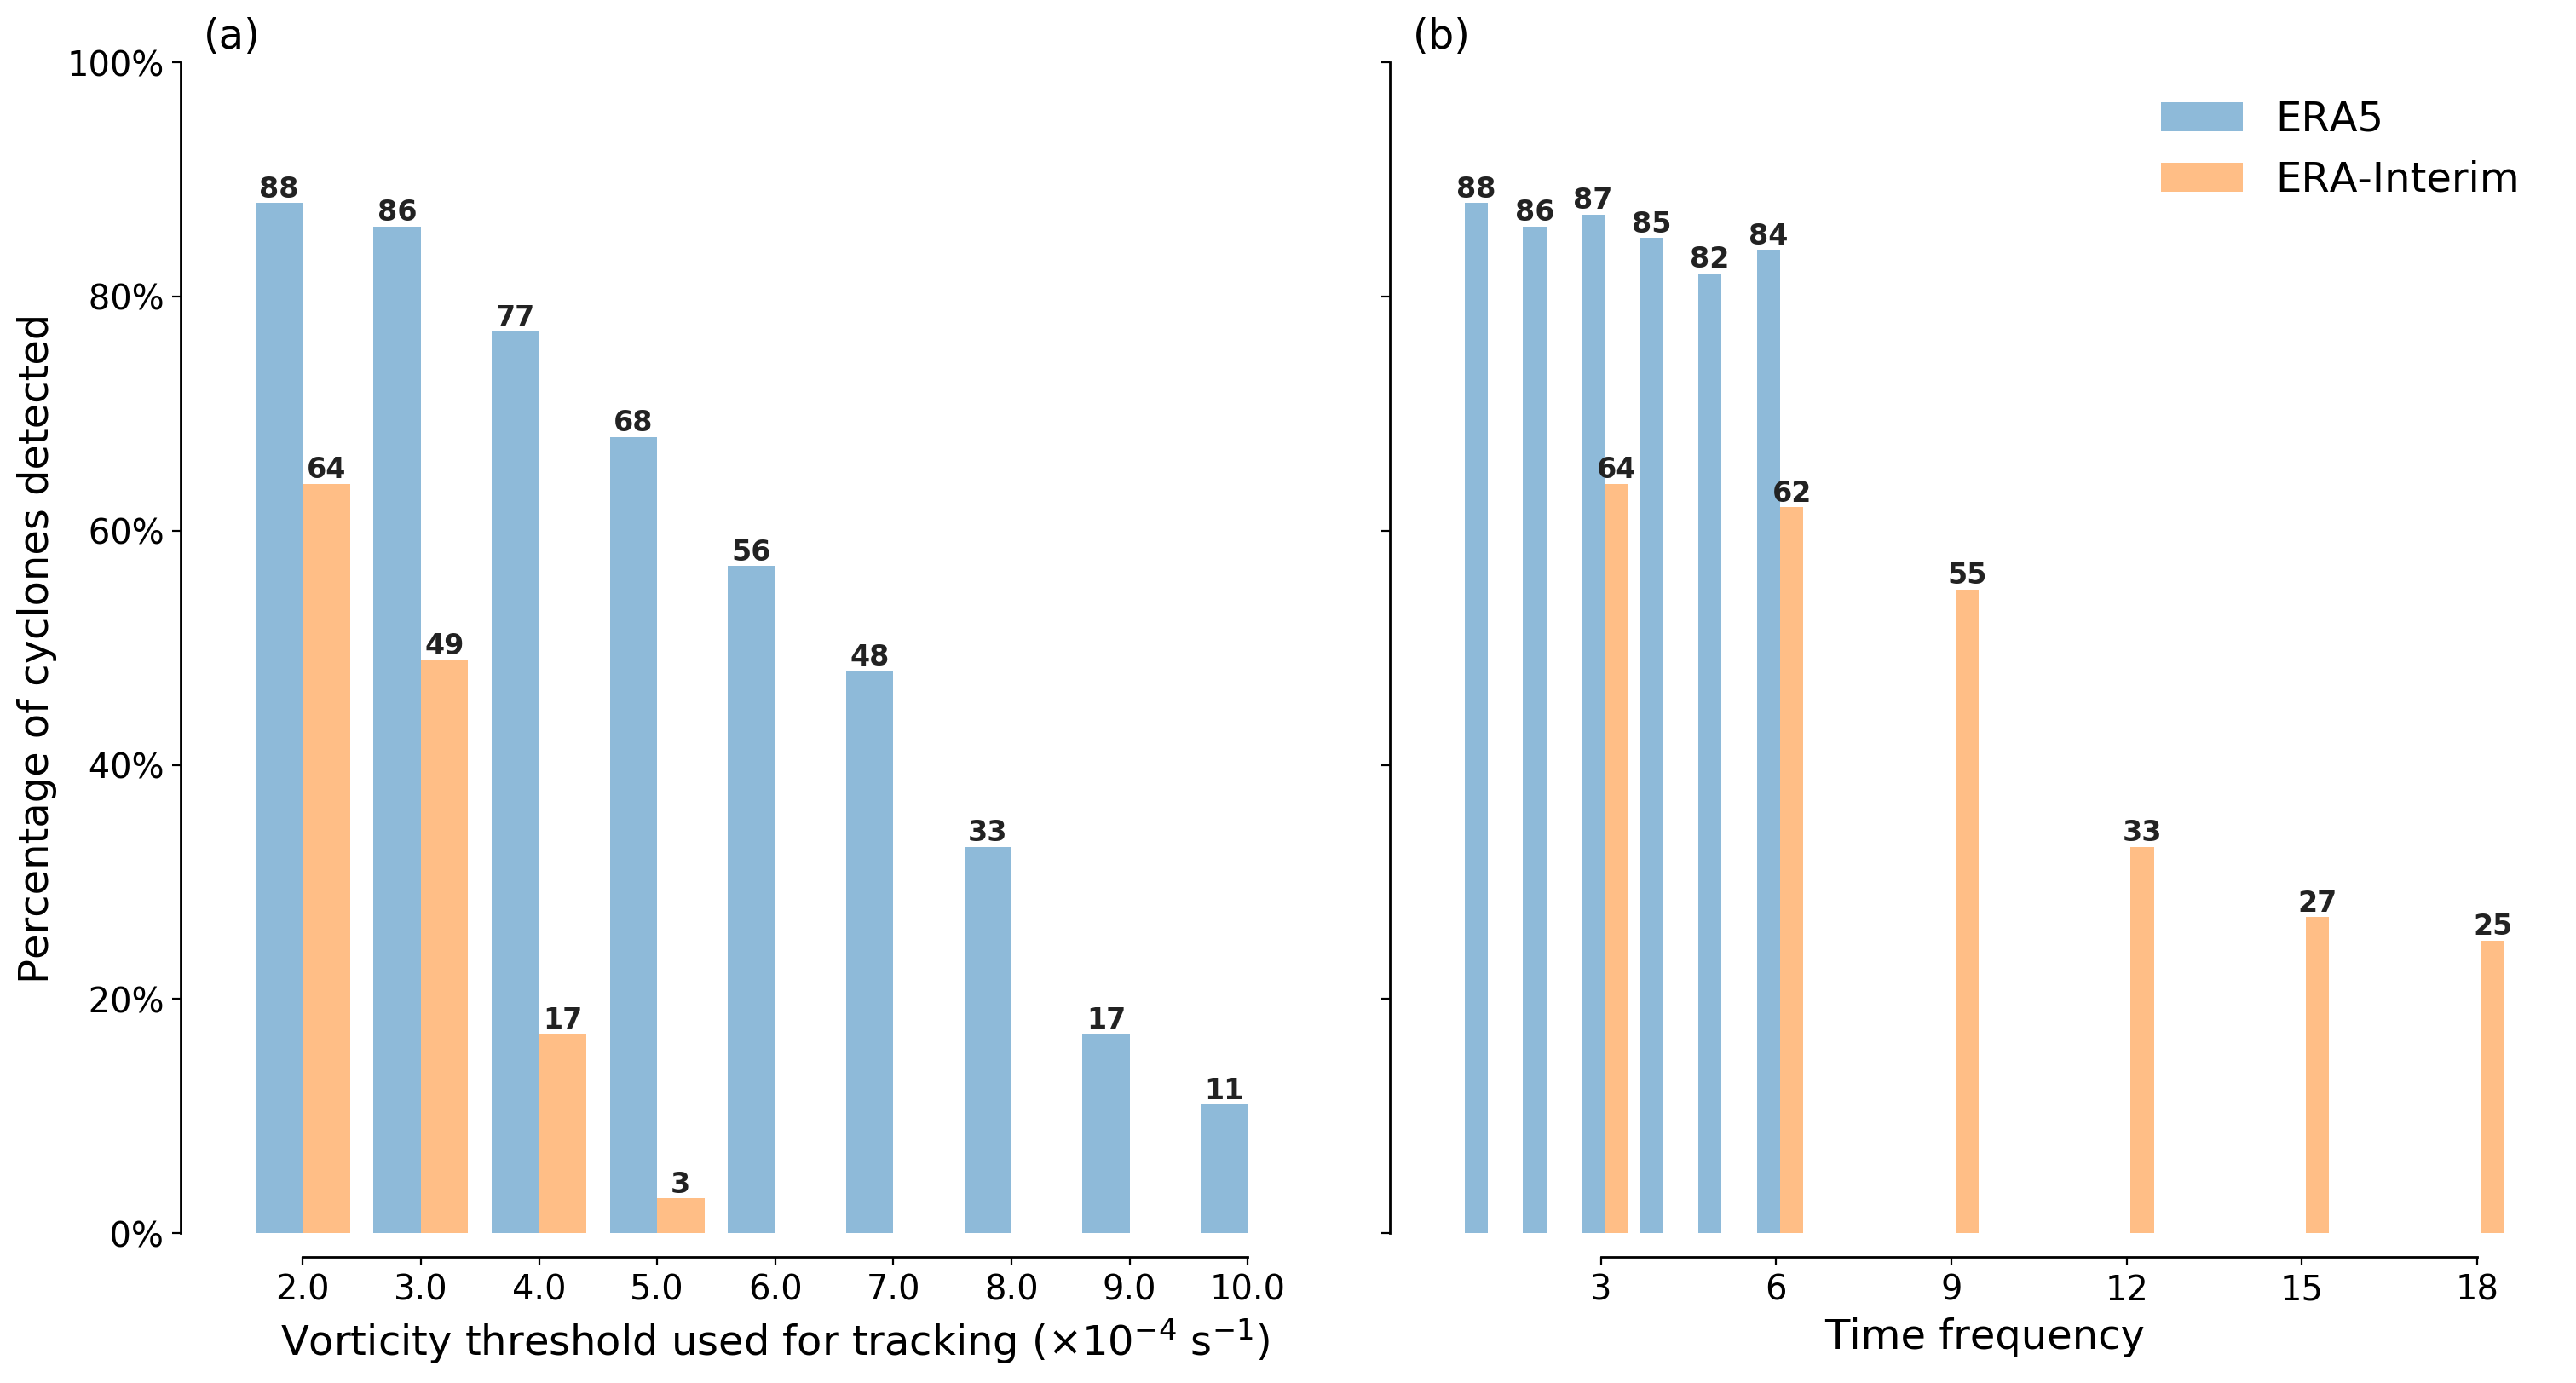

In [11]:
fig, axs = plt.subplots(ncols=2, constrained_layout=True, sharey=True)

width = 0.4

ax = axs[0]
indices, xvalues = np.asarray(
    [
        [i, r.get("zeta_max0", 2.0e-4)]
        for i, r in enumerate(runs_grid)
        if "zeta_max0" in r or len(r) == 0
    ]
).T
xindices = np.arange(len(indices))

for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        match_counts = matrices[dataset][match_i, indices.astype(int)]
        ax.bar(
            xindices + j * width,
            match_counts / n_ref,
            width=width,
            **color,
            alpha=0.5 * (i + 1),
            linewidth=0.75,
            label=f"{aliases[dataset]}",
        )

_add_style_and_labels(ax, xindices, (1e4 * xvalues).round(decimals=1), n_ref, width=0.4)

ax.set_xlabel(
    r"Vorticity threshold used for tracking ($\times10^{-4}$ $s^{-1}}$)", fontsize="x-large"
)

# Time frequency
ax = axs[1]
indices, xvalues = np.asarray(
    [[i, r.get("tfreq", 1)] for i, r in enumerate(runs_grid) if "tfreq" in r or len(r) == 0]
).T
xindices = np.arange(len(indices)) + 1

for j, (dataset, color) in enumerate(zip(datasets, cc)):
    for i, (subset) in enumerate(subsets):
        match_counts = matrices[dataset][match_i, indices.astype(int)]
        ax.bar(
            xindices * dset_ctrl_tstep_h[dataset] + j * width,
            match_counts / n_ref,
            width=width,
            **color,
            alpha=0.5 * (i + 1),
            linewidth=0.75,
            label=f"{aliases[dataset]}",
        )

_add_style_and_labels(ax, xindices * max(dset_ctrl_tstep_h.values()), xvalues * max(dset_ctrl_tstep_h.values()), n_ref, width=0.4 * 6 / 9, add_ylabel=False)

ax.set_xlabel(r"Time frequency", fontsize="x-large")

axs[1].legend(loc=1, ncol=1, fontsize="x-large", frameon=False)

for ilab, ax in zip(string.ascii_lowercase, axs):
    ax.set_title(f"({ilab})", loc="left", size="x-large")

In [12]:
fig.savefig(mypaths.plotdir / f"vrf__vort_thresh__tfreq__bs2000_100")